In [1]:
import os
import numpy as np
import mindspore as ms
from mindspore import context, Tensor
from mindspore.train import Model
from mindspore.train.serialization import load_checkpoint, load_param_into_net
from mindspore.dataset.transforms import vision
from mindspore.nn import Softmax, Sigmoid
from PIL import Image
import matplotlib.pyplot as plt

from resnet50_arch import resnet50

In [2]:
cfg = {
    'HEIGHT': 224,
    'WIDTH': 224,
    '_R_MEAN': 123.68,
    '_G_MEAN': 116.78,
    '_B_MEAN': 103.94,
    '_R_STD': 1,
    '_G_STD': 1,
    '_B_STD': 1,
    'num_class': 2, 
    'model_path': '../best_model.ckpt'
}

In [3]:
class_names = {0: 'Normal', 1: 'Tuberculosis'}

In [4]:
def preprocess_image(image_path):
    
    image = Image.open(image_path).convert('RGB')
    image = image.resize((cfg['WIDTH'], cfg['HEIGHT']))
    image = np.array(image).astype(np.float32)
    
    # Normalize the image
    image = (image - [cfg['_R_MEAN'], cfg['_G_MEAN'], cfg['_B_MEAN']]) / [cfg['_R_STD'], cfg['_G_STD'], cfg['_B_STD']]
    image = np.transpose(image, (2, 0, 1))
    image = np.expand_dims(image, axis=0) 
    
    return Tensor(image, ms.float32)

def load_model():

    net = resnet50(class_num=cfg['num_class'])
    
    param_dict = load_checkpoint(cfg['model_path'])
    load_param_into_net(net, param_dict)
    
    model = Model(net)
    
    return model

def predict(image_path):

    image = preprocess_image(image_path)
    model = load_model()

    # Predict and calculate confidence level
    output = model.predict(image)
    softmax = Softmax()
    probabilities = softmax(output).asnumpy()
    predicted_class = np.argmax(probabilities, axis=1)[0]
    
    return class_names[predicted_class], probabilities[0][predicted_class]

def spotum_AI(image_path):

    predicted_class, confidence = predict(image_path)
    
    print(f"Prediction: {predicted_class}")
    print(f"Confidence: {confidence:.2f}")

    # Dispaly the results accordingly
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_class} ({confidence:.2f})")
    plt.axis('off')
    plt.show()

****************************************************************** SPOTUM AI ******************************************************************

Prediction: Tuberculosis
Confidence: 1.00


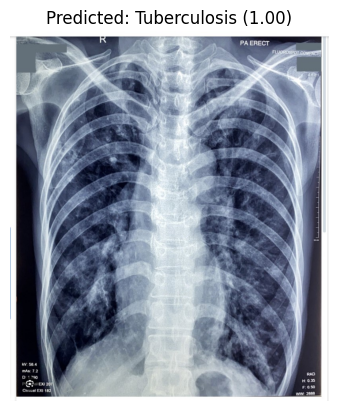

OK


In [6]:

if __name__ == '__main__':
    print("****************************************************************** SPOTUM AI ******************************************************************\n");
    image_path = input("\tEnter the filename/path of chest radiography image: ")
    if os.path.exists(image_path):
        spotum_AI(image_path)
        print("OK")
    else:
        print(f"Error: File '{image_path}' does not exist.")